In [81]:
!pip install numpy==1.26
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install xgboost
!pip install catboost
!pip install imbalanced-learn
!pip install joblib

In [279]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, learning_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib

In [280]:
train_data = pd.read_csv('archive/GUIDE_Train.csv',  nrows=10000)

In [281]:
train_data['Category'].unique()

array(['InitialAccess', 'Exfiltration', 'CommandAndControl', 'Execution',
       'SuspiciousActivity', 'Impact', 'Collection', 'CredentialAccess',
       'Persistence', 'Discovery', 'Malware', 'DefenseEvasion', 'Exploit',
       'PrivilegeEscalation', 'LateralMovement', 'Ransomware',
       'UnwantedSoftware'], dtype=object)

In [282]:
train_data['Category'].unique()
train_data['CountryCode'].unique()
train_data.iloc[:,:15].head()
train_data.iloc[:, [0, 9] + list(range(15, 30))].head()
train_data.iloc[:, [0, 9] + list(range(30, 45))].head()
train_data['IncidentGrade'].value_counts()
train_data['IncidentGrade'].value_counts() * 100 / train_data['IncidentGrade'].shape[0]
train_data.isnull().sum()

Id                       0
OrgId                    0
IncidentId               0
AlertId                  0
Timestamp                0
DetectorId               0
AlertTitle               0
Category                 0
MitreTechniques       5799
IncidentGrade           53
ActionGrouped         9941
ActionGranular        9941
EntityType               0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
AccountObjectId          0
AccountName              0
DeviceName               0
NetworkMessageId         0
EmailClusterId        9881
RegistryKey              0
RegistryValueName        0
RegistryValueData        0
ApplicationId            0
ApplicationName          0
OAuthApplicationId       0
ThreatFamily          9923
FileName                 0
FolderPath               0
ResourceIdName           0
ResourceType          9992
Roles                 9789
O

In [283]:
le_cat_columns = ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict',
                  'ResourceType', 'Roles', 'AntispamDirection', 'ThreatFamily','CountryCode',
                  'OSFamily', 'OSVersion','State', 'City', 'RegistryValueName', 'RegistryValueData', 
                  'ResourceIdName', 'RegistryKey', 'OAuthApplicationId', 'ApplicationId', 'ApplicationName']

numerical_columns = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
                     'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'FileName', 'FolderPath']

le_cat_columns += numerical_columns

numerical_columns = []

ohe_cat_columns = []

In [284]:
train_data[le_cat_columns].nunique().sort_values(ascending=False)
train_data[numerical_columns].nunique().sort_values(ascending=False)

Series([], dtype: float64)

In [285]:
for col in train_data:
    if train_data[col].nunique() < 10:
        print(col, train_data[col].unique())

IncidentGrade ['TruePositive' 'FalsePositive' 'BenignPositive' nan]
ActionGrouped [nan 'ContainAccount' 'IsolateDevice']
ActionGranular [nan 'account password changed'
 'update stsrefreshtokenvalidfrom timestamp.' 'account disabled'
 'disable account.' 'isolateresponse' 'reset user password.'
 'change user password.' 'quarantinefile'
 'msecidentitiesconfirmusercompromised']
EvidenceRole ['Related' 'Impacted']
RegistryValueName [635   0  28  10  89]
RegistryValueData [860  25  94   0]
OAuthApplicationId [881   2   0]
ResourceType [nan 'Virtual Machine' 'API Management Service' 'Networking'
 'Azure Resource' 'Azure Arc machine']
Roles [nan 'Contextual' 'Destination' 'Attacker' 'Compromised' 'Suspicious'
 'Source']
OSFamily [5 0 2]
OSVersion [66  0  1  3 16  4]
AntispamDirection [nan 'Inbound' 'Intraorg']
SuspicionLevel [nan 'Suspicious' 'Incriminated']
LastVerdict [nan 'Suspicious' 'Malicious' 'NoThreatsFound']


In [286]:
def preprocess_data(df, le_cat_columns):
    """
        This function preprocesses the dataset
    """
    
    # Converts columns with fewer than 20 unique values to ohe categorical columns
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Converts numerical to label encoded categorical columns
    for le_col in le_cat_columns:
        df[le_col] = df[le_col].astype('object')

    return df

In [287]:
train_data = preprocess_data(train_data, le_cat_columns)

In [288]:
print(train_data[le_cat_columns].nunique())
print(train_data[ohe_cat_columns].nunique())
print(train_data[numerical_columns].nunique())

Category                17
EntityType              20
EvidenceRole             2
SuspicionLevel           2
LastVerdict              3
ResourceType             5
Roles                    6
AntispamDirection        2
ThreatFamily            59
CountryCode             68
OSFamily                 3
OSVersion                6
State                  136
City                   196
RegistryValueName        5
RegistryValueData        4
ResourceIdName          12
RegistryKey             10
OAuthApplicationId       3
ApplicationId           21
ApplicationName         23
DeviceId               375
Sha256                 512
IpAddress             1879
Url                    603
AccountSid            2211
AccountUpn            3386
AccountObjectId       2200
AccountName           2323
DeviceName             686
NetworkMessageId      1193
EmailClusterId         114
FileName               706
FolderPath             465
dtype: int64
Series([], dtype: float64)
Series([], dtype: float64)


In [289]:
cat_columns = ohe_cat_columns + le_cat_columns

# stats_data = pd.DataFrame()

for cat in cat_columns:
    # One-Hot Encode the categorical data
    onehot_encoder = OneHotEncoder(sparse_output=False)  # Adjust for the FutureWarning
    X_encoded = onehot_encoder.fit_transform(train_data[[cat]])  # Use double brackets to pass a 2D array
    
    # ANOVA F-Statistic
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(train_data['IncidentGrade'])  # Assuming IncidentGrade is categorical
    f_statistic, p_value = f_classif(X_encoded, y)
    
    print("*" * 20)
    print(f"Feature: {cat}")
    print(f"ANOVA F-Statistic: {f_statistic}")
    print(f"p-Value: {p_value}")

********************
Feature: Category
ANOVA F-Statistic: [  7.00254755  92.58639546   3.09948296   6.49285618   9.79556804
  11.838447   299.46458326   0.61664621   7.26672376 546.64932359
  10.88150204   7.96114589  17.81756912   1.70405179  10.34171089
  15.17589261   1.04381464]
p-Value: [1.05950479e-004 4.24174750e-059 2.56200184e-002 2.19538767e-004
 1.89503308e-006 9.76713575e-008 3.55756337e-186 6.04145409e-001
 7.25665378e-005 0.00000000e+000 3.92457716e-007 2.67683745e-005
 1.57225136e-011 1.63840000e-001 8.58899200e-007 7.50932599e-010
 3.71848977e-001]
********************
Feature: EntityType
ANOVA F-Statistic: [  1.2465377    2.15773925   4.56910177 276.71322975  61.30340991
  57.40804916   0.85163764  68.85139816  71.39049445   2.75570284
 109.33946921   4.88714971   0.64581447   2.49425806  24.32592096
   9.3422696    5.10165539   1.2465377   33.63333252  77.87348648]
p-Value: [2.91049643e-001 9.07954176e-002 3.34548278e-003 1.50364845e-172
 2.88396644e-039 8.69618565e-0

In [290]:
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Id                  10000 non-null  int64              
 1   OrgId               10000 non-null  int64              
 2   IncidentId          10000 non-null  int64              
 3   AlertId             10000 non-null  int64              
 4   Timestamp           10000 non-null  datetime64[ns, UTC]
 5   DetectorId          10000 non-null  int64              
 6   AlertTitle          10000 non-null  int64              
 7   Category            10000 non-null  object             
 8   MitreTechniques     4201 non-null   object             
 9   IncidentGrade       9947 non-null   object             
 10  ActionGrouped       59 non-null     object             
 11  ActionGranular      59 non-null     object             
 12  EntityType          10000 non-nul

In [291]:
def process_data():
    train_data = pd.read_csv('archive/GUIDE_Train.csv') 
    test_data = pd.read_csv('archive/GUIDE_Test.csv')
    
    print(train_data.shape)
    
    # Drop rows with missing target variable 'IncidentGrade'
    train_data.dropna(subset=['IncidentGrade'], inplace=True)
    
    train_data = preprocess_data(train_data, le_cat_columns)
    test_data = preprocess_data(test_data, le_cat_columns)
    
    group_columns = ohe_cat_columns + numerical_columns + le_cat_columns
    
    # Drop duplicates based on the specified columns
    train_data = train_data.drop_duplicates(subset=group_columns)
    
    # Drop usage column as it is not present in train dataset
    test_data.drop(['Usage'], axis=1, inplace=True)
    
    print(train_data.shape)
    print(test_data.shape)
    
    #  One hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(train_data[ohe_cat_columns])

    train_data_ohe = csr_matrix(ohe.transform(train_data[ohe_cat_columns]))
    test_data_ohe = csr_matrix(ohe.transform(test_data[ohe_cat_columns]))

    # Fill NaNs for numerical columns
    train_data_numerical = csr_matrix(train_data[numerical_columns].fillna(-1).values)
    test_data_numerical = csr_matrix(test_data[numerical_columns].fillna(-1).values)
    
    # Feature label encoding
    feature_le = LabelEncoder()
    
    train_data_le = pd.DataFrame()
    test_data_le = pd.DataFrame()
    
    # Fit and transform the feature variables
    for le_col in le_cat_columns:
        # we want to stack train and test for label encoding of some cat variables
        feature_le.fit(pd.concat([train_data[le_col], test_data[le_col]]))
        train_data_le[le_col] = feature_le.transform(train_data[le_col])
        test_data_le[le_col] = feature_le.transform(test_data[le_col])
    
    train_data_le = csr_matrix(train_data_le)
    test_data_le = csr_matrix(test_data_le)
    
    X_train = hstack([train_data_ohe, train_data_le ,train_data_numerical])
    X_test = hstack([test_data_ohe, test_data_le, test_data_numerical])

    # Target label encoding
    target_le = LabelEncoder()
    
    # Fit and transform the target variable
    target_le.fit(train_data['IncidentGrade'])
    y_train = target_le.transform(train_data['IncidentGrade'])
    y_test = target_le.transform(test_data['IncidentGrade'])
    
    # Print out the label classes of the target variable
    """
        0: 'BenignPositive'
        1: 'FalsePositive'
        2: 'TruePositive'
    """
    print(f"Target Classes: {target_le.classes_}")
        
    return X_train, y_train, X_test, y_test
    
    
# get the data
X_train, y_train, X_test, y_test = process_data()

C:\Users\Chella Vignesh K P\AppData\Local\Temp\ipykernel_17112\2898853772.py:3: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv('archive/GUIDE_Test.csv')


(9516837, 45)
(2489784, 45)
(4147992, 45)
Target Classes: ['BenignPositive' 'FalsePositive' 'TruePositive']


In [292]:
def predict(model, X_test, y_test):
    # Generate predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Print accuracy
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Print confusion matrix
    print("\nConfusion Matrix:")
    
    cm = confusion_matrix(y_test, y_pred)
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                        display_labels = ['BenignPositive', 'FalsePositive', 'TruePositive'])

    cm_display.plot()
    plt.show()

    return y_pred

In [293]:
def train_random_forest_classifier(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    
    model.fit(X_train, y_train)
    
    # Feature importance
    importances = model.feature_importances_
    
    feature_columns = np.array(ohe_cat_columns + le_cat_columns + numerical_columns)
    
    # Plot feature importance
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances (Random Forest Classifier)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_columns[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return model

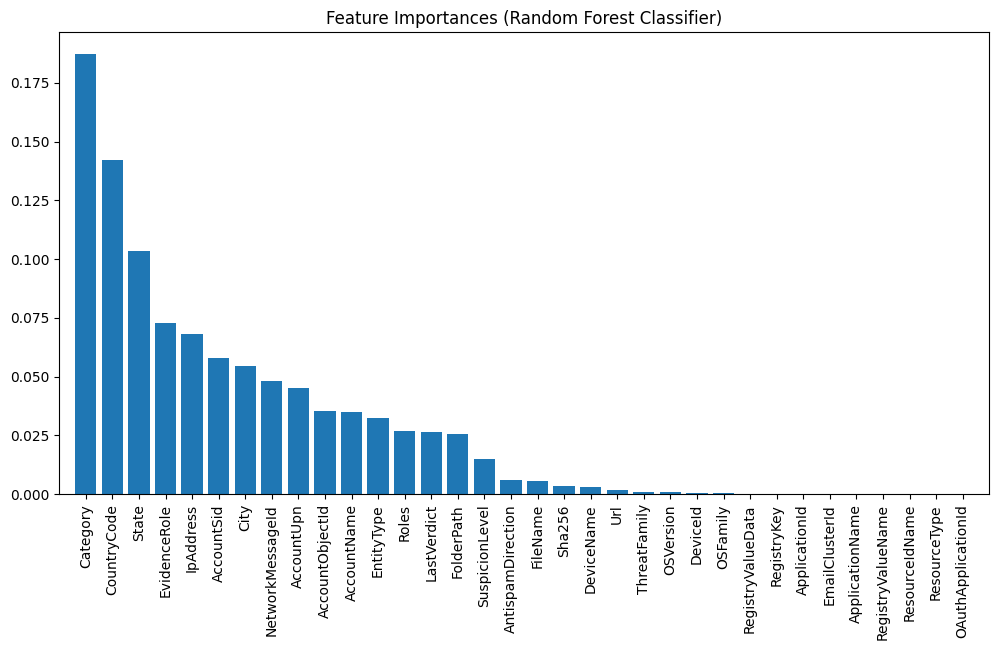

In [294]:
rfc_model = train_random_forest_classifier(X_train, y_train)

Accuracy: 0.4987

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.99      0.63   1752940
           1       0.64      0.06      0.10    902698
           2       0.94      0.18      0.31   1492354

    accuracy                           0.50   4147992
   macro avg       0.68      0.41      0.35   4147992
weighted avg       0.67      0.50      0.40   4147992


Confusion Matrix:


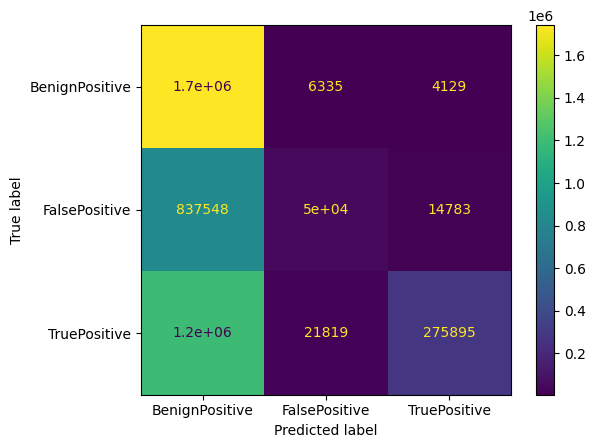

Accuracy: 0.49873239871243724
Macro-Precision: 0.6796399756953511
Macro-Recall: 0.4115663417201833
Macro-F1 Score: 0.3472925853310953


In [295]:
y_pred = predict(rfc_model, X_test, y_test)

# evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

In [296]:
def train_xgboost_classifier(X_train, y_train):
    model = XGBClassifier(n_estimators=100, max_depth=5, random_state=0, use_label_encoder=False, eval_metric='mlogloss')
    
    model.fit(X_train, y_train)
    
    # Feature importance
    importances = model.feature_importances_
    
    feature_columns = np.array(ohe_cat_columns + le_cat_columns + numerical_columns)
    
    # Plot feature importance
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances (XGBoost Classifier)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_columns[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return model

C:\Users\Chella Vignesh K P\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [23:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


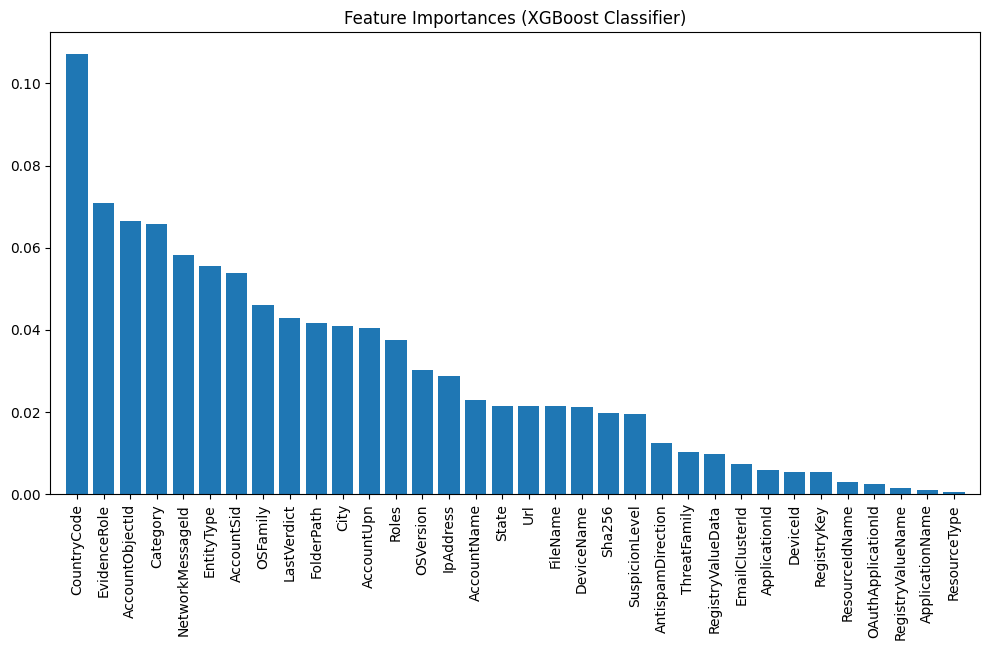

In [297]:
xgb_model = train_xgboost_classifier(X_train, y_train)

Accuracy: 0.6029

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.93      0.68   1752940
           1       0.77      0.26      0.39    902698
           2       0.83      0.42      0.56   1492354

    accuracy                           0.60   4147992
   macro avg       0.71      0.54      0.54   4147992
weighted avg       0.69      0.60      0.57   4147992


Confusion Matrix:


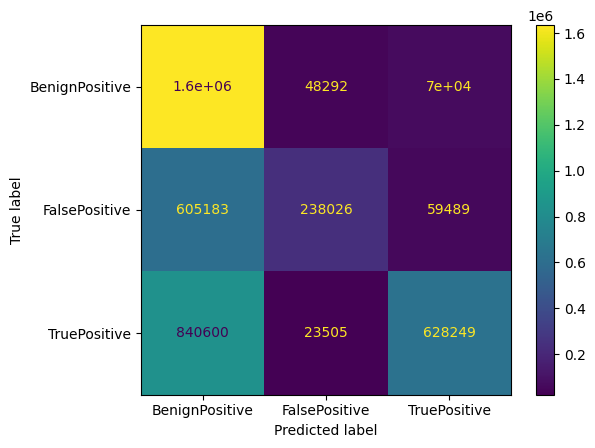

Accuracy: 0.6028707384199391
Macro-Precision: 0.7092523387645663
Macro-Recall: 0.5390179477047033
Macro-F1 Score: 0.5424400279719604


In [298]:
y_pred = predict(xgb_model, X_test, y_test)

# evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

In [299]:
def train_catboost_classifier(X_train, y_train):
    model = CatBoostClassifier(iterations=100, depth=5, random_seed=0, verbose=0)
    
    model.fit(X_train, y_train)
    
    # Feature importance
    importances = model.get_feature_importance()
    
    feature_columns = np.array(ohe_cat_columns + le_cat_columns + numerical_columns)
    
    # Plot feature importance
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances (CatBoost Classifier)")
    plt.bar(range(X_train.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train.shape[1]), feature_columns[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

    return model

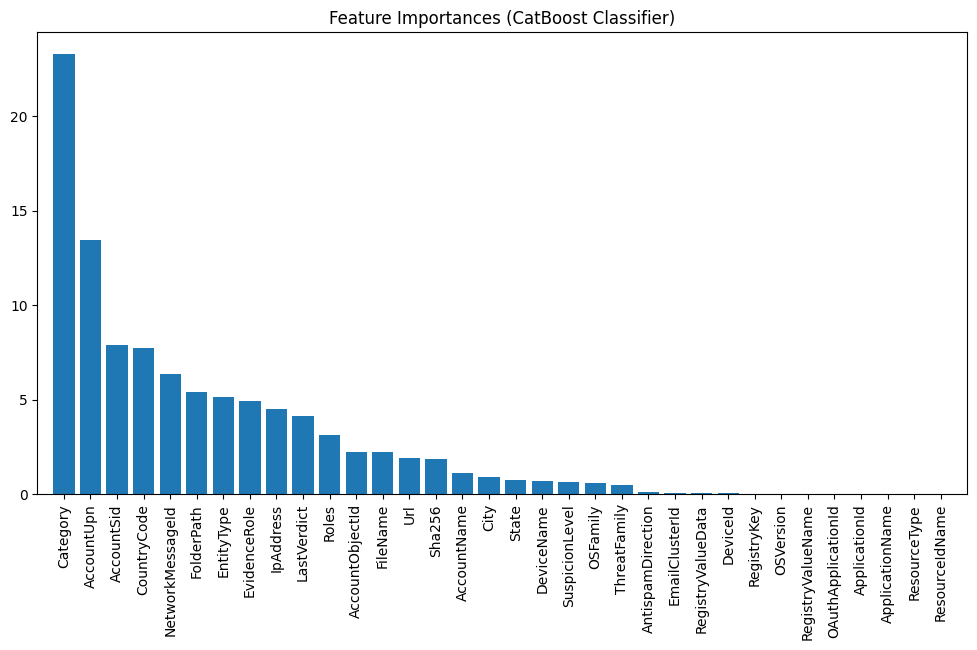

In [300]:
cat_model = train_catboost_classifier(X_train, y_train)

Accuracy: 0.5881

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.87      0.66   1752940
           1       0.69      0.27      0.38    902698
           2       0.71      0.45      0.55   1492354

    accuracy                           0.59   4147992
   macro avg       0.65      0.53      0.53   4147992
weighted avg       0.63      0.59      0.56   4147992


Confusion Matrix:


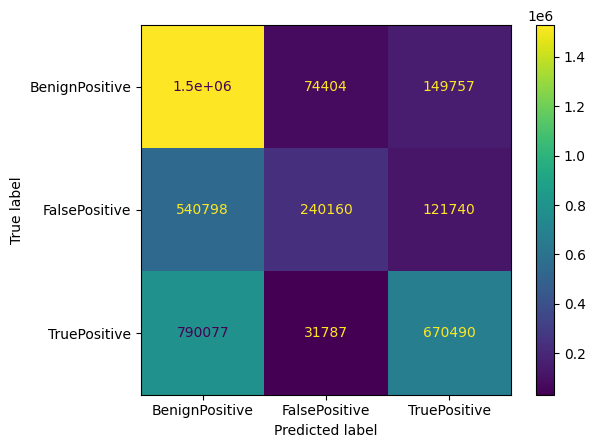

Accuracy: 0.5880987716466184
Macro-Precision: 0.6465953532230254
Macro-Recall: 0.5291510698704879
Macro-F1 Score: 0.5327599379596503


In [301]:
y_pred = predict(cat_model, X_test, y_test)

# evaluate test performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

In [302]:
# Load dataset
data = load_iris()
X, y = data.data, data.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define model
rf = RandomForestClassifier()

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}


In [303]:
# Load dataset (replace with your dataset)
X, y = load_iris(return_X_y=True)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)

# Define model with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create pipeline
pipeline = Pipeline([
    ('smote', smote),
    ('classifier', rf)
])

# Train model
pipeline.fit(X_train, y_train)

# Evaluate model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [304]:
# Load dataset
X, y = load_iris(return_X_y=True)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define base models
model1 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Create Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', model1),
    ('gb', model2)
], voting='soft')

# Train Voting Classifier
voting_clf.fit(X_train, y_train)

# Evaluate model
y_pred = voting_clf.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred))

Voting Classifier Accuracy: 1.0


In [305]:
y_train = y_train.ravel()

# Initialize LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Check for NaN or infinite values in data
print("NaN values in X_train:", np.any(np.isnan(X_train)))
print("NaN values in y_train:", np.any(np.isnan(y_train)))
print("Infinite values in X_train:", np.any(np.isinf(X_train)))
print("Infinite values in y_train:", np.any(np.isinf(y_train)))

# Handle NaN or infinite values if found
X_train = np.nan_to_num(X_train)  # Replace NaNs with 0
y_train = np.nan_to_num(y_train)  # Replace NaNs with 0

# Define the models
xgb_model = XGBClassifier(eval_metric='logloss')
catboost_model = CatBoostClassifier(verbose=0)
rf_model = RandomForestClassifier()

# Define the parameter grid for each model
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1]
}

catboost_param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Set up the GridSearchCV for each model
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
catboost_grid = GridSearchCV(estimator=catboost_model, param_grid=catboost_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the models
xgb_grid.fit(X_train, y_train_encoded)
catboost_grid.fit(X_train, y_train_encoded)
rf_grid.fit(X_train, y_train_encoded)

# Get the best parameters
print("Best XGBoost Params: ", xgb_grid.best_params_)
print("Best CatBoost Params: ", catboost_grid.best_params_)
print("Best Random Forest Params: ", rf_grid.best_params_)

NaN values in X_train: False
NaN values in y_train: False
Infinite values in X_train: False
Infinite values in y_train: False
Best XGBoost Params:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CatBoost Params:  {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best Random Forest Params:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


In [306]:
# Use the best parameters found by GridSearchCV
best_xgb = XGBClassifier(**xgb_grid.best_params_)
best_catboost = CatBoostClassifier(**catboost_grid.best_params_, verbose=0)
best_rf = RandomForestClassifier(**rf_grid.best_params_)

# Evaluate using cross-validation
xgb_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='accuracy')
catboost_scores = cross_val_score(best_catboost, X_train, y_train, cv=5, scoring='accuracy')
rf_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')

print("XGBoost Cross-Validation Accuracy: ", xgb_scores.mean())
print("CatBoost Cross-Validation Accuracy: ", catboost_scores.mean())
print("Random Forest Cross-Validation Accuracy: ", rf_scores.mean())


XGBoost Cross-Validation Accuracy:  0.9333333333333333
CatBoost Cross-Validation Accuracy:  0.9428571428571428
Random Forest Cross-Validation Accuracy:  0.9333333333333333


In [307]:
# Train the final models on the full training data
best_xgb.fit(X_train, y_train)
best_catboost.fit(X_train, y_train)
best_rf.fit(X_train, y_train)

# Predict on the validation/test set
xgb_preds = best_xgb.predict(X_test)
catboost_preds = best_catboost.predict(X_test)
rf_preds = best_rf.predict(X_test)

# Evaluate the models
print("XGBoost Test Accuracy: ", accuracy_score(y_test, xgb_preds))
print("CatBoost Test Accuracy: ", accuracy_score(y_test, catboost_preds))
print("Random Forest Test Accuracy: ", accuracy_score(y_test, rf_preds))

print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_preds))
print("\nCatBoost Classification Report:\n", classification_report(y_test, catboost_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))

XGBoost Test Accuracy:  1.0
CatBoost Test Accuracy:  1.0
Random Forest Test Accuracy:  1.0

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


CatBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


Random Forest Classification Report:
               precision    recall  f1-sco

In [308]:
# Split data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Train models with training data
best_xgb.fit(X_train, y_train)
best_catboost.fit(X_train, y_train)
best_rf.fit(X_train, y_train)

# Validate models with validation data
xgb_val_preds = best_xgb.predict(X_val)
catboost_val_preds = best_catboost.predict(X_val)
rf_val_preds = best_rf.predict(X_val)


print("XGBoost Validation Accuracy: ", accuracy_score(y_val, xgb_val_preds))
print("CatBoost Validation Accuracy: ", accuracy_score(y_val, catboost_val_preds))
print("Random Forest Validation Accuracy: ", accuracy_score(y_val, rf_val_preds))


XGBoost Validation Accuracy:  0.9166666666666666
CatBoost Validation Accuracy:  0.9583333333333334
Random Forest Validation Accuracy:  0.9166666666666666


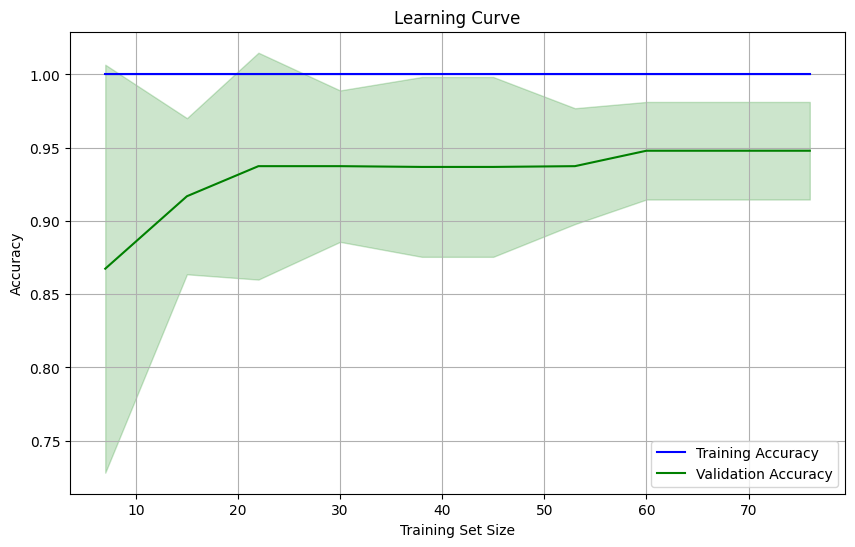

Saved best model to best_catboost_model.pkl


In [309]:
best_model = None
if xgb_scores.mean() > catboost_scores.mean() and xgb_scores.mean() > rf_scores.mean():
    best_model = best_xgb
    model_filename = 'best_xgb_model.pkl'
elif catboost_scores.mean() > rf_scores.mean():
    best_model = best_catboost
    model_filename = 'best_catboost_model.pkl'
else:
    best_model = best_rf
    model_filename = 'best_rf_model.pkl'

# Train the best model on the full training data
best_model.fit(X_train, y_train)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)  # Different sizes of the training set
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', color='green')

# Plot the fill between for the standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

# Save the model
joblib.dump(best_model, model_filename)
print(f'Saved best model to {model_filename}')